In [6]:
import torch
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM

MID = "apple/FastVLM-0.5B"
IMAGE_TOKEN_INDEX = -200  # what the model code looks for

# Load
tok = AutoTokenizer.from_pretrained(MID, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MID,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    trust_remote_code=True,
)

# Build chat -> render to string (not tokens) so we can place <image> exactly
messages = [
    {"role": "user", "content": "1.png\nDescribe this image in detail."}
]
rendered = tok.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=False
)

pre, post = rendered.split("1.png", 1)

# Tokenize the text *around* the image token (no extra specials!)
pre_ids  = tok(pre,  return_tensors="pt", add_special_tokens=False).input_ids
post_ids = tok(post, return_tensors="pt", add_special_tokens=False).input_ids

# Splice in the IMAGE token id (-200) at the placeholder position
img_tok = torch.tensor([[IMAGE_TOKEN_INDEX]], dtype=pre_ids.dtype)
input_ids = torch.cat([pre_ids, img_tok, post_ids], dim=1).to(model.device)
attention_mask = torch.ones_like(input_ids, device=model.device)

# Preprocess image via the model's own processor
img = Image.open("1.png").convert("RGB")
px = model.get_vision_tower().image_processor(images=img, return_tensors="pt")["pixel_values"]
# Ensure the pixel values are on the correct device and dtype
px = px.to(model.device, dtype=model.dtype)


# Generate
with torch.no_grad():
    out = model.generate(
        inputs=input_ids,
        attention_mask=attention_mask,
        images=px,
        max_new_tokens=12,
    )

print(tok.decode(out[0], skip_special_tokens=True))

The image shows a browser window displaying a "Login Agent"


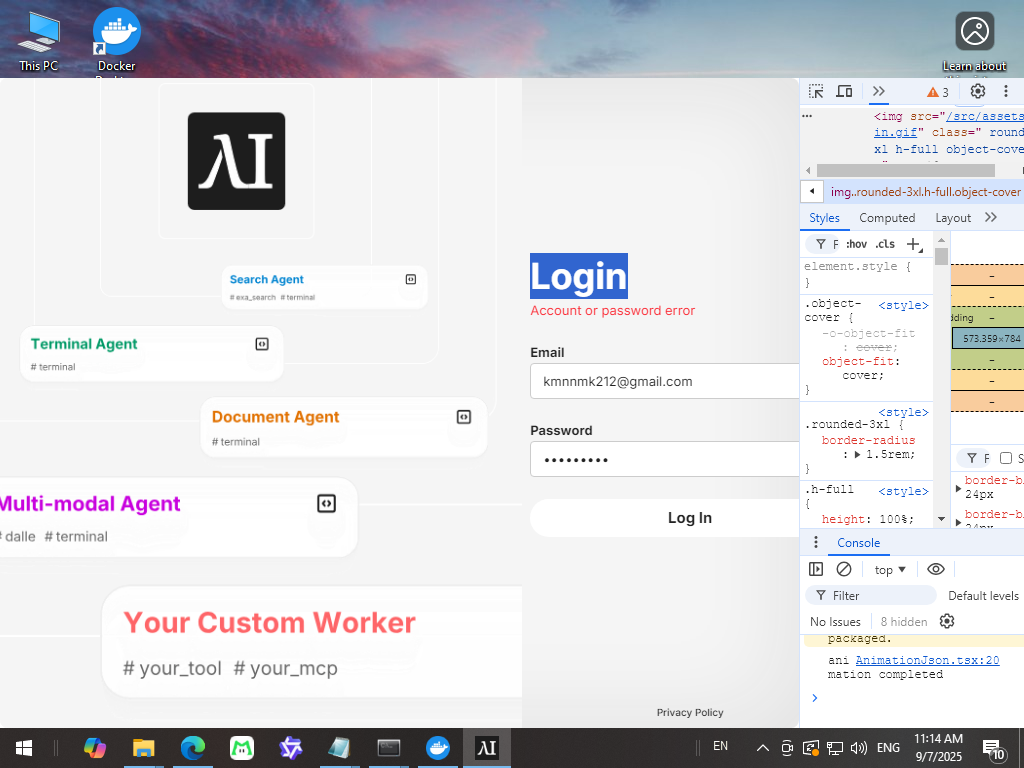

In [7]:
from IPython.display import display, Image

# Replace 'path/to/your/image.jpg' with the actual path to your image file
image_path = '/content/1.png' # Example path from your current files

try:
  display(Image(filename=image_path))
except FileNotFoundError:
  print(f"Error: The file '{image_path}' was not found.")
except Exception as e:
  print(f"An error occurred: {e}")